# Discretização
- https://scikit-learn.org/stable/modules/preprocessing.html#discretization
- **Transforma atributos contínuos de um conjunto de dados em atributos nominais**
    - segundo a própria documentação, é o particionamento de recursos contínuos em valores discretos

### KBinsDiscretizer
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html#sklearn.preprocessing.KBinsDiscretizer
- Divide os dados contínuos em intervalos, podendo ser ajustado de acordo com o parâmetro **`strategy`** para que todos os intervalos tenham o **mesmo comprimento** (**`uniform`**), um **número similar de pontos** (**`quantile`**, default) ou até mesmo baseado em um procedimento de agrupamento de k-means (**`kmeans`**)
- O **`encode`** define a forma que sera codificado o resultado transformado, em geral usamos **`onehot`** para termos o retorno em colunas e **`ordinal`** para valores numéricos

In [1]:
# Importando o pandas
import pandas as pd

In [2]:
# Importando os dados do titanic após as etapas de Data Cleaning
titanic = pd.read_csv('train2.csv')

In [3]:
# Visualizando a tabela
titanic.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Titulos
0,0,3,male,22.0,1,0,7.2500,S,Mr
1,1,1,female,38.0,1,0,71.2833,C,Mrs


In [4]:
# Importando o KBinsDiscretizer
from sklearn.preprocessing import KBinsDiscretizer

In [5]:
# Definindo nossa discretização
est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

In [6]:
# Fazendo o fit com a coluna Fare
est = est.fit(titanic[['Fare']])

In [7]:
# Transformando os dados
titanic['Fare_disc'] = est.transform(titanic[['Fare']])

In [8]:
# Visualizando os dados gerados
titanic.Fare_disc.value_counts()

0.0    838
1.0     33
2.0     17
4.0      3
Name: Fare_disc, dtype: int64

In [9]:
# Salvando a contagem de valores em uma variável
contagem = titanic.Fare_disc.value_counts().values
contagem

array([838,  33,  17,   3])

In [10]:
# Adicionando 0 para o valor 3
import numpy as np
contagem = np.insert(contagem,3,0)
contagem

array([838,  33,  17,   0,   3])

- Podemos utilizar o aggregate do pandas junto ao group by para verificar o mínimo, máximo e contagem de registros dos grupos gerados
    - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.aggregate.html

In [11]:
# Verificando o intervalo em cada um desses grupos
grupos = titanic.groupby('Fare_disc')['Fare'].agg(['min','max','count']).reset_index()
grupos

,Fare_disc,min,max,count
0,0.0,0.0000,93.5000,838
1,1.0,106.4250,164.8667,33
2,2.0,211.3375,263.0000,17
3,4.0,512.3292,512.3292,3


In [12]:
# Calculando os comprimentos
grupos['comp'] = grupos['max'] - grupos['min']
grupos

,Fare_disc,min,max,count,comp
0,0.0,0.0000,93.5000,838,93.5000
1,1.0,106.4250,164.8667,33,58.4417
2,2.0,211.3375,263.0000,17,51.6625
3,4.0,512.3292,512.3292,3,0.0000


- O comprimento vai ser calculando considerando todo o range e dividindo em 5. Depois os pontos serão agrupando considerando cada uma dessas 5 regiões

In [13]:
# Verificando os dados estatísticos da coluna Fare
titanic.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [14]:
# Calculando o range
titanic.Fare.max() - titanic.Fare.min()

512.3292

In [15]:
# Dividindo esse range em 5
(titanic.Fare.max() - titanic.Fare.min()) / 5

102.46584

- Podemos utilizar o **`bin_edges_`** para determinar os limites dos grupos criados

In [16]:
# Podemos utilizar o bin_edges para verificar os limites dos grupos gerados
est.bin_edges_[0][:5]

array([  0.     , 102.46584, 204.93168, 307.39752, 409.86336])

- Vamos utilizar o barplot para visualizar graficamente
    - https://matplotlib.org/stable/plot_types/basic/bar.html#sphx-glr-plot-types-basic-bar-py

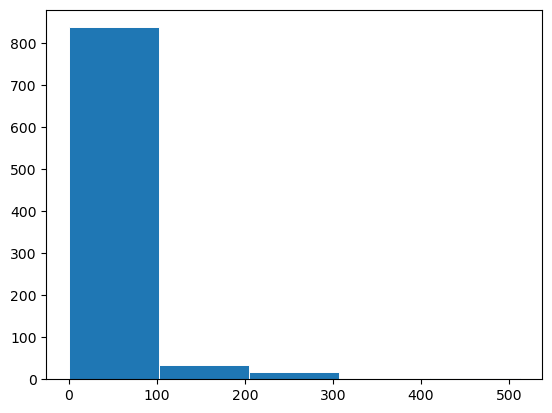

In [17]:
# Utilizando um gráfico de barras para visualizar
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.bar(est.bin_edges_[0][:5], 
       contagem, 
       width=(titanic.Fare.max() - titanic.Fare.min()) / 5
       , edgecolor="white", linewidth=0.7,
      align='edge')

plt.show()

- Podemos utilizar `strategy=quantile` para que cada região tenha a mesma quantidade de registros
    - Segundo a documentação: **"usa os valores dos quantis para ter compartimentos igualmente preenchidos"**

In [18]:
# Definindo nossa discretização
est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

In [19]:
# Fazendo o fit com a coluna Fare
est = est.fit(titanic[['Fare']])

In [20]:
# Transformando os dados
titanic['Fare_quant'] = est.transform(titanic[['Fare']])

In [21]:
# Visualizando os dados gerados
titanic.Fare_quant.value_counts().sort_index().values

array([166, 173, 195, 175, 182])

In [22]:
# Salvando a contagem de valores em uma variável
valores = titanic.Fare_quant.value_counts().sort_index().values
valores

array([166, 173, 195, 175, 182])

In [23]:
# Verificando o intervalo em cada um desses grupos
grupos = titanic.groupby('Fare_quant')['Fare'].agg(['min','max','count']).reset_index()
grupos['comp'] = grupos['max'] - grupos['min']
grupos

,Fare_quant,min,max,count,comp
0,0.0,0.0000,7.8292,166,7.8292
1,1.0,7.8542,10.4625,173,2.6083
2,2.0,10.5000,21.0750,195,10.5750
3,3.0,21.6792,39.6000,175,17.9208
4,4.0,39.6875,512.3292,182,472.6417


In [24]:
# Novamente utilizando o bin_edges
est.bin_edges_

array([array([  0.    ,   7.8542,  10.5   ,  21.6792,  39.6875, 512.3292])],
      dtype=object)

- Podemos então verificar os **quantis** da coluna Fare
    - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.quantile.html
    - Obs: **quartil é o quantil quando dividimos a base em 4 partes iguais**

In [25]:
# Verificando os quantis que dividem essa base em 5 regiões
titanic.Fare.quantile([0,0.2,0.4,0.6,0.8,1])

0.0      0.0000
0.2      7.8542
0.4     10.5000
0.6     21.6792
0.8     39.6875
1.0    512.3292
Name: Fare, dtype: float64

In [26]:
# Podemos visualizar o comprimento de cada uma dessas regiões
comp = est.bin_edges_[0][1:6]-est.bin_edges_[0][0:5]
comp

array([  7.8542,   2.6458,  11.1792,  18.0083, 472.6417])

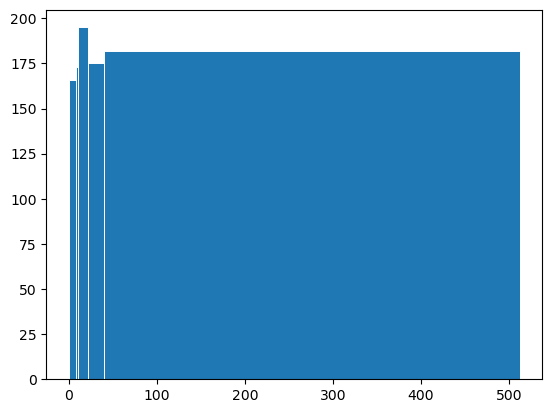

In [27]:
# Utilizando um gráfico de barras para visualizar
fig, ax = plt.subplots()

ax.bar(est.bin_edges_[0][:5], 
       valores, 
       width=comp
       , edgecolor="white", linewidth=0.7,
      align='edge')

plt.show()

### Binarização
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Binarizer.html#sklearn.preprocessing.Binarizer
- **Transforma os dados em binários** (0 - se valor for menor ou igual ao limite ou 1 - valor maior que o limite) **baseado em um limite** informado como parâmetro
    - **`threshold`**: limite usado para classificação dos valores
- **Podemos fazer a binarização na coluna SibSp para determinar se as pessoas estavam viajando sozinhas (SibSp == 0) ou acompanhadas dos irmãos / conjuges (SibSp > 0)**  
    - Para isso, **podemos considerar o limite igual a 0** (que é o valor default), por exemplo

In [28]:
# Visualizando os valores de Parch
titanic.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [29]:
# Importando o Binarizer
from sklearn.preprocessing import Binarizer

In [31]:
# Criando a binarização
binari = Binarizer(threshold=0.5)

In [32]:
# Fazendo o fit
binari = binari.fit(titanic[['Parch']])

In [34]:
# Fazendo a transformação
titanic['Viagem_so'] = binari.transform(titanic[['Parch']])

In [36]:
# Visualizando os valores
titanic[['Parch','Viagem_so']].value_counts()

Parch  Viagem_so
0      0            678
1      1            118
2      1             80
3      1              5
5      1              5
4      1              4
6      1              1
dtype: int64